In [5]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=4454ba6a7441f74cfbf8b2622766b99395a40fcb9df1730ad290398853276fb9
  Stored in directory: /root/.cache/pip/wheels/01/46/3b/e29ffbe4ebe614ff224bad40fc6a5773a67a163251585a13a9
Successfully built wget


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import os
from pathlib import Path
from tqdm.auto import tqdm
import numpy as np
import wget
import torch
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss, Conv2d, BatchNorm2d
from torch.optim import SGD, lr_scheduler
import torchvision
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Resnet9
class Mul(torch.nn.Module):
    def __init__(self, weight):
        super(Mul, self).__init__()
        self.weight = weight
    def forward(self, x): return x * self.weight


class Flatten(torch.nn.Module):
    def forward(self, x): return x.view(x.size(0), -1)


class Residual(torch.nn.Module):
    def __init__(self, module):
        super(Residual, self).__init__()
        self.module = module
    def forward(self, x): return x + self.module(x)


def construct_rn9(num_classes=10):
    def conv_bn(channels_in, channels_out, kernel_size=3, stride=1, padding=1, groups=1):
        return torch.nn.Sequential(
                torch.nn.Conv2d(channels_in, channels_out, kernel_size=kernel_size,
                            stride=stride, padding=padding, groups=groups, bias=False),
                torch.nn.BatchNorm2d(channels_out),
                torch.nn.ReLU(inplace=True)
        )
    model = torch.nn.Sequential(
        conv_bn(3, 64, kernel_size=3, stride=1, padding=1),
        conv_bn(64, 128, kernel_size=5, stride=2, padding=2),
        Residual(torch.nn.Sequential(conv_bn(128, 128), conv_bn(128, 128))),
        conv_bn(128, 256, kernel_size=3, stride=1, padding=1),
        torch.nn.MaxPool2d(2),
        Residual(torch.nn.Sequential(conv_bn(256, 256), conv_bn(256, 256))),
        conv_bn(256, 128, kernel_size=3, stride=1, padding=0),
        torch.nn.AdaptiveMaxPool2d((1, 1)),
        Flatten(),
        torch.nn.Linear(128, num_classes, bias=False),
        Mul(0.2)
    )
    return model

In [8]:
from torchvision.datasets import ImageFolder
from torchvision import transforms

transform = transforms.ToTensor()
train_dataset = ImageFolder(root='/content/task1/easy/train', transform=transform)
val_dataset = ImageFolder(root='/content/task1/easy/val', transform=transform)

# This dataset will automatically find 3 classes (cat, dog, bird)
# and assign integer labels (e.g., cat=0, dog=1, bird=2)

In [9]:
def get_dataloader(batch_size=256, num_workers=8, split='train', shuffle=False, augment=True):
    if augment:
        transforms = torchvision.transforms.Compose(
                        [torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
                          torchvision.transforms.RandomHorizontalFlip(),
                         torchvision.transforms.RandomAffine(0),
                         torchvision.transforms.ToTensor(),
                         torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                          (0.2023, 0.1994, 0.201))])
    else:
        transforms = torchvision.transforms.Compose([
                                  torchvision.transforms.Resize(256), torchvision.transforms.CenterCrop(224),
                         torchvision.transforms.ToTensor(),
                         torchvision.transforms.Normalize((0.4914, 0.4822, 0.4465),
                                                          (0.2023, 0.1994, 0.201))])

    is_train = (split == 'train')
    # dataset = torchvision.datasets.CIFAR10(root='/tmp/cifar/',
    #                                        download=True,
    #                                        train=is_train,
    #                                        transform=transforms)
    if is_train:
      dataset = ImageFolder(root='/content/task1/easy/train', transform=transforms)
    else:
      dataset = ImageFolder(root='/content/task1/easy/val', transform=transforms)


    loader = torch.utils.data.DataLoader(dataset=dataset,
                                         shuffle=shuffle,
                                         batch_size=batch_size,
                                         num_workers=num_workers)

    return loader

In [10]:
!find /content/task1/easy/train -type f -name "*.jpg" | wc -l

403


In [11]:
def train(model, loader, lr=0.4, epochs=24, momentum=0.9,
          weight_decay=5e-4, lr_peak_epoch=5, label_smoothing=0.0, model_id=0):

    opt = SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
    iters_per_epoch = len(loader)
    # Cyclic LR with single triangle
    lr_schedule = np.interp(np.arange((epochs+1) * iters_per_epoch),
                            [0, lr_peak_epoch * iters_per_epoch, epochs * iters_per_epoch],
                            [0, 1, 0])
    scheduler = lr_scheduler.LambdaLR(opt, lr_schedule.__getitem__)
    scaler = GradScaler()
    loss_fn = CrossEntropyLoss(label_smoothing=label_smoothing)

    for ep in range(epochs):
        print(ep)
        for it, (ims, labs) in enumerate(loader):
            ims = ims.cuda()
            labs = labs.cuda()
            opt.zero_grad(set_to_none=True)
            with autocast():
                out = model(ims)
                loss = loss_fn(out, labs)

            scaler.scale(loss).backward()
            scaler.step(opt)
            scaler.update()
            scheduler.step()
        if ep in [12, 15, 18, 21, 23]:
            torch.save(model.state_dict(), f'./checkpoints/sd_{model_id}_epoch_{ep}.pt')

    return model

In [12]:
os.makedirs('./checkpoints', exist_ok=True)
loader_for_training = get_dataloader(batch_size=32, split='train', shuffle=True)

# you can modify the for loop below to train more models
for i in tqdm(range(1), desc='Training models..'):
    model = construct_rn9().to(memory_format=torch.channels_last).cuda()
    model = train(model, loader_for_training, model_id=i)

Training models..:   0%|          | 0/1 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23


In [13]:
ckpt_files = sorted(list(Path('./checkpoints').rglob('*.pt')))
ckpts = [torch.load(ckpt, map_location='cpu') for ckpt in ckpt_files]

# Check test accuracy

In [14]:
model = construct_rn9().to(memory_format=torch.channels_last).cuda()
model.load_state_dict(ckpts[-1])
model = model.eval()

In [15]:
loader = get_dataloader(split='val', augment=False)
model.eval()

with torch.no_grad():
    total_correct, total_num = 0., 0.
    for ims, labs in tqdm(loader):
        ims = ims.cuda()
        labs = labs.cuda()
        with autocast():
            out = model(ims)
            total_correct += out.argmax(1).eq(labs).sum().cpu().item()
            total_num += ims.shape[0]

    print(f'Accuracy: {total_correct / total_num * 100:.1f}%')

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy: 91.0%


# TRAK

In [16]:
batch_size = 16
loader_train = get_dataloader(batch_size=batch_size, split='train')

In [22]:
!pip install fast_jl traker

  Preparing metadata (setup.py) ... done
  Created wheel for traker: filename=traker-0.3.2-py3-none-any.whl size=28985 sha256=0230d4e2a863580abdd2cbab3123fc0dbddbae454b1d0bc456443a7efae62bf9
  Stored in directory: /root/.cache/pip/wheels/6f/9c/93/cacba5ebe6989142debfcab420506346a9b9d6cd7bae112161
Successfully built traker


In [23]:
from trak import TRAKer

traker = TRAKer(model=model,
                task='image_classification',
                proj_dim=4096,
                train_set_size=len(loader_train.dataset))

INFO:STORE:No existing model IDs in /content/trak_results.
INFO:STORE:No existing TRAK scores in /content/trak_results.


## Compute TRAK features for train data

In [24]:
for model_id, ckpt in enumerate(tqdm(ckpts)):
    traker.load_checkpoint(ckpt, model_id=model_id)
    for batch in tqdm(loader_train):
        batch = [x.cuda() for x in batch]
        traker.featurize(batch=batch, num_samples=batch[0].shape[0])

traker.finalize_features()

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

Finalizing features for all model IDs..: 100%|██████████| 5/5 [00:00<00:00,  8.10it/s]


## Compute TRAK scores for targets

In [25]:
loader_targets = get_dataloader(batch_size=batch_size, split='val', augment=False)

In [26]:
for model_id, ckpt in enumerate(tqdm(ckpts)):
    traker.start_scoring_checkpoint(exp_name='quickstart',
                                    checkpoint=ckpt,
                                    model_id=model_id,
                                    num_targets=len(loader_targets.dataset))
    for batch in loader_targets:
        batch = [x.cuda() for x in batch]
        traker.score(batch=batch, num_samples=batch[0].shape[0])

scores = traker.finalize_scores(exp_name='quickstart')

  0%|          | 0/5 [00:00<?, ?it/s]

Finalizing scores for all model IDs..: 100%|██████████| 5/5 [00:00<00:00, 99.05it/s]
INFO:STORE:Saving scores in /content/trak_results/scores/quickstart.mmap


In [27]:
from numpy.lib.format import open_memmap
_scores = open_memmap('./trak_results/scores/quickstart.mmap')

## Visualize TRAK scores

In [28]:
from matplotlib import pyplot as plt

In [60]:
!rm -fr /content/task1/easy/val/.ipynb_checkpoints

In [61]:
# ds_train = torchvision.datasets.CIFAR10(root='/tmp/cifar/', download=True, train=True)
# ds_val = torchvision.datasets.CIFAR10(root='/tmp/cifar/', download=True, train=False)

ds_train = ImageFolder(root='/content/task1/easy/train', transform=transform)
ds_val = ImageFolder(root='/content/task1/easy/val', transform=transform)

val class 1
train id (174): 0
train id (165): 0
train id (343): 1
train id (391): 1
train id (230): 1
val class 1
train id (174): 0
train id (46): 0
train id (13): 0
train id (124): 0
train id (343): 1
val class 1
train id (345): 1
train id (375): 1
train id (253): 1
train id (366): 1
train id (352): 1


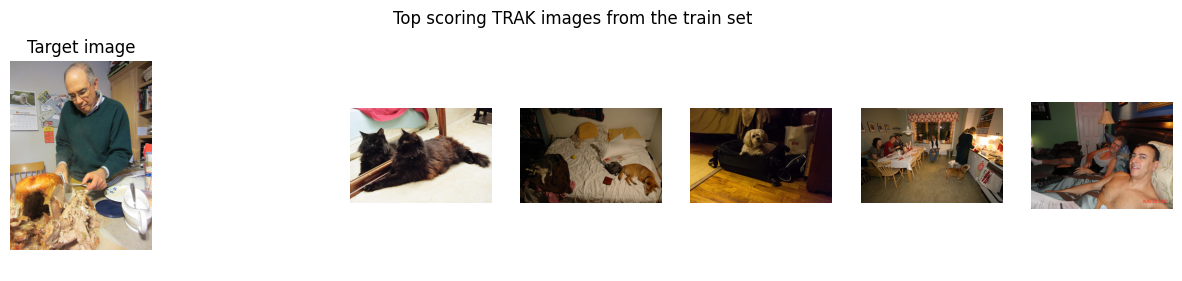

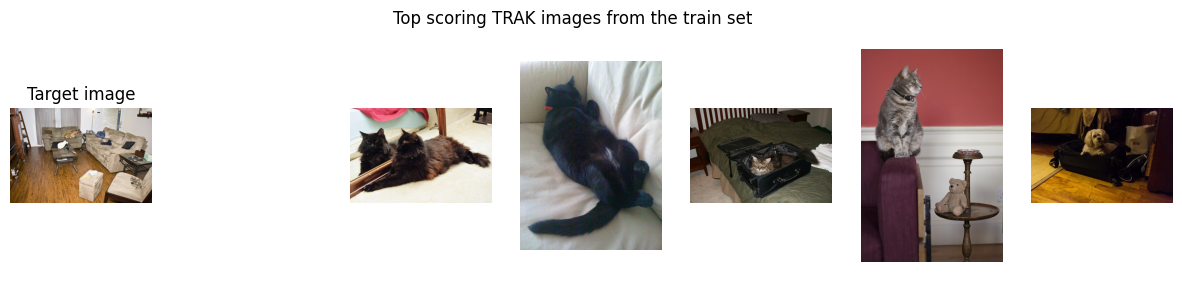

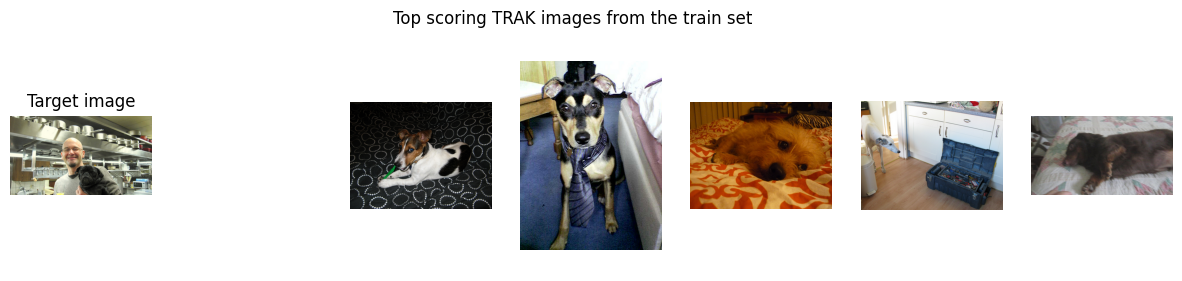

In [62]:
for i in [7, 21, 22]:

    fig, axs = plt.subplots(ncols=7, figsize=(15, 3))
    fig.suptitle('Top scoring TRAK images from the train set')

    axs[0].imshow(ds_val[i][0].permute(1, 2, 0))

    axs[0].axis('off'); axs[0].set_title('Target image')
    axs[1].axis('off')
    print(f'val class {ds_val[i][1]}')
    top_trak_scorers = scores[:, i].argsort()[-5:][::-1]
    for ii, train_im_ind in enumerate(top_trak_scorers):
        print(f'train id ({train_im_ind}): {ds_train[train_im_ind][1]}')
        axs[ii + 2].imshow(ds_train[train_im_ind][0].permute(1, 2, 0)); axs[ii + 2].axis('off')
    print('='*40)
    fig.show()